<a href="https://colab.research.google.com/github/YoneJ/Final/blob/main/Individual_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [5]:
df = pd.read_csv('/content/Lidar-Center-1.csv')
df = pd.read_csv('/content/Lidar-Left-1.csv')
df = pd.read_csv('/content/Lidar-Right-1.csv')

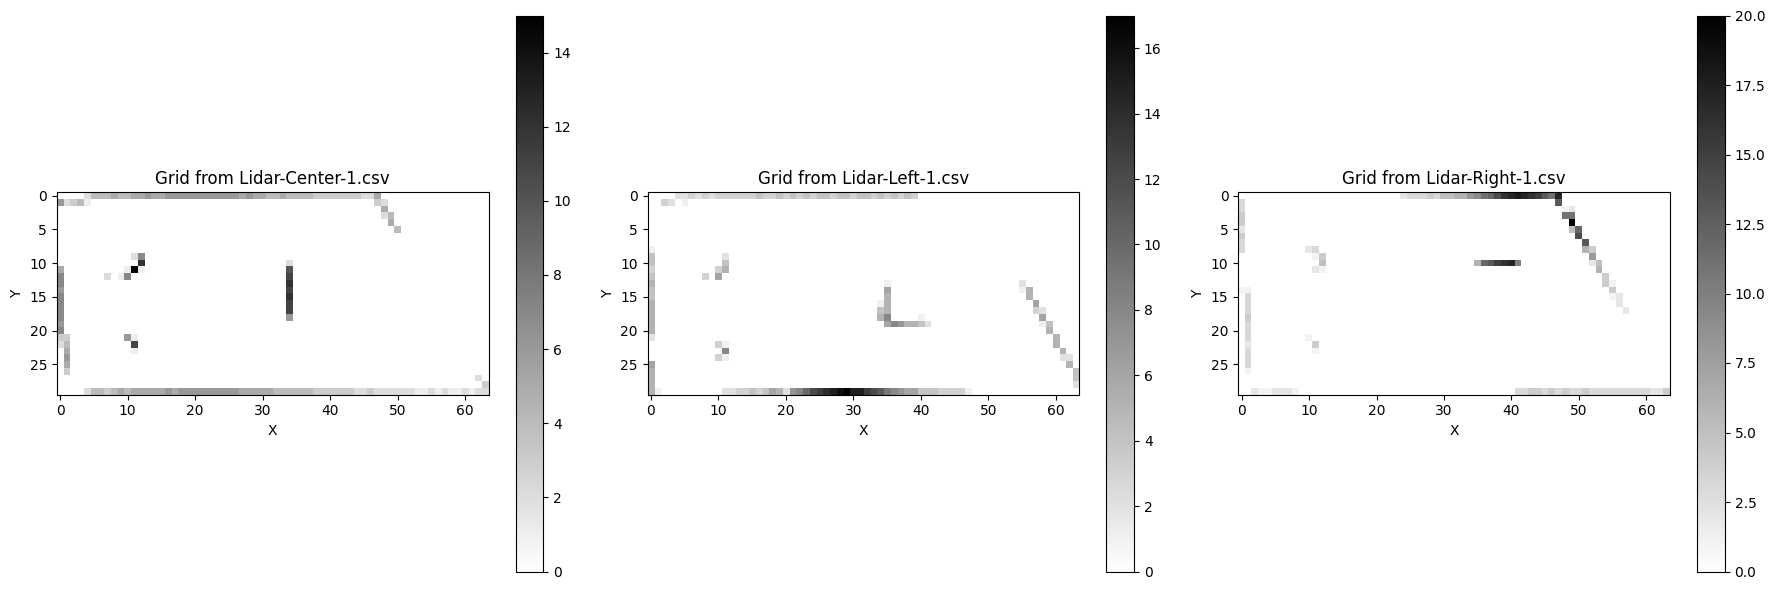

In [15]:
def process_data(file_name):
    df = pd.read_csv(file_name)
    x = df['x'].values
    y = df['y'].values
    x_grid = np.clip(np.floor((x - min(x)) / (max(x) - min(x)) * 64), 0, 63).astype(int)
    y_grid = np.clip(np.floor((y - min(y)) / (max(y) - min(y)) *30), 0, 29).astype(int)
    grid = np.zeros((30, 64))

    for i in range(len(x_grid)):
        grid[y_grid[i], x_grid[i]] += 1

    return grid

files = ['Lidar-Center-1.csv', 'Lidar-Left-1.csv', 'Lidar-Right-1.csv']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, file in enumerate(files):
    grid = process_data(file)
    ax = axes[i]
    norm = Normalize(vmin=0, vmax=np.max(grid))
    cax = ax.imshow(grid[::-1], cmap='binary', interpolation='nearest', norm=norm)
    ax.set_title(f'Grid from {file}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    fig.colorbar(cax, ax=ax, orientation='vertical')

plt.tight_layout()
plt.show()


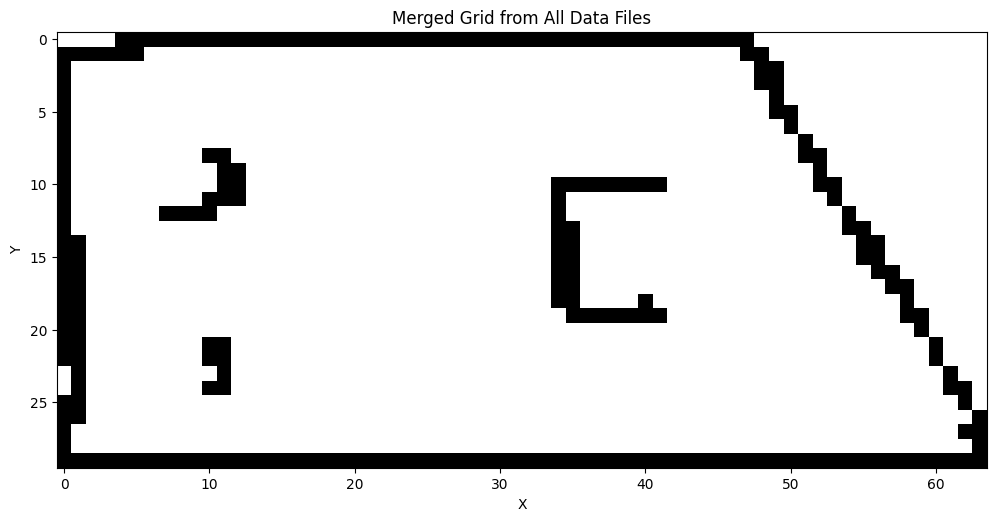

In [21]:
def process_data(file_name):
    df = pd.read_csv(file_name)
    x = df['x'].values
    y = df['y'].values
    x_grid = np.clip(np.floor((x - min(x)) / (max(x) - min(x)) * 64), 0, 63).astype(int)
    y_grid = np.clip(np.floor((y - min(y)) / (max(y) - min(y)) * 30), 0, 29).astype(int)

    grid = np.zeros((30, 64), dtype=int)

    for i in range(len(x_grid)):
        grid[y_grid[i], x_grid[i]] = 1

    return grid

files = ['Lidar-Center-1.csv', 'Lidar-Left-1.csv', 'Lidar-Right-1.csv']

merged_grid = np.zeros((30, 64))

for file in files:
    grid = process_data(file)
    merged_grid = np.maximum(merged_grid, grid)
merged_grid_flipped_vertical = np.flipud(merged_grid)

np.save('merged_grid_flipped_vertical.npy', merged_grid_flipped_vertical)


plt.figure(figsize=(12, 10))
plt.imshow(merged_grid_flipped_vertical, cmap='binary', interpolation='nearest')
plt.title('Merged Grid from All Data Files')
plt.xlabel('X')
plt.ylabel('Y')

plt.colorbar(cax, orientation='vertical')
plt.show()



In [38]:
import numpy as np
import heapq

DIRECTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)]

def heuristic(a, b):
    """Calculate the Manhattan distance (L1 norm) between two points."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(grid, start, end):
    """A* pathfinding algorithm."""
    open_list = []
    closed_list = set()

    start_x, start_y = start
    end_x, end_y = end

    g_cost = {start: 0}
    f_cost = {start: heuristic(start, end)}
    parents = {start: None}

    heapq.heappush(open_list, (f_cost[start], start))

    while open_list:
        current_f, current_node = heapq.heappop(open_list)
        current_x, current_y = current_node

        if current_node == end:
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = parents[current_node]
            return path[::-1]

        closed_list.add(current_node)

        for dx, dy in DIRECTIONS:
            neighbor = (current_x + dx, current_y + dy)

            if not (0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]):
                continue
            if grid[neighbor[0], neighbor[1]] == 1:
                continue
            if neighbor in closed_list:
                continue

            tentative_g = g_cost[current_node] + 1

            if neighbor not in g_cost or tentative_g < g_cost[neighbor]:
                g_cost[neighbor] = tentative_g
                f_cost[neighbor] = tentative_g + heuristic(neighbor, end)
                parents[neighbor] = current_node
                heapq.heappush(open_list, (f_cost[neighbor], neighbor))

    return None

start_point = (15, 20)
end_point = (15, 45)

path = a_star(merged_grid_flipped_vertical, start_point, end_point)

if path:
    print("Path found:", path)
    np.save('pathA*.npy', path)
else:
    print("No path found.")

Path found: [(15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (15, 28), (15, 29), (15, 30), (16, 31), (17, 32), (18, 33), (19, 34), (20, 35), (20, 36), (20, 37), (20, 38), (20, 39), (20, 40), (20, 41), (19, 42), (18, 43), (17, 44), (16, 45), (15, 45)]


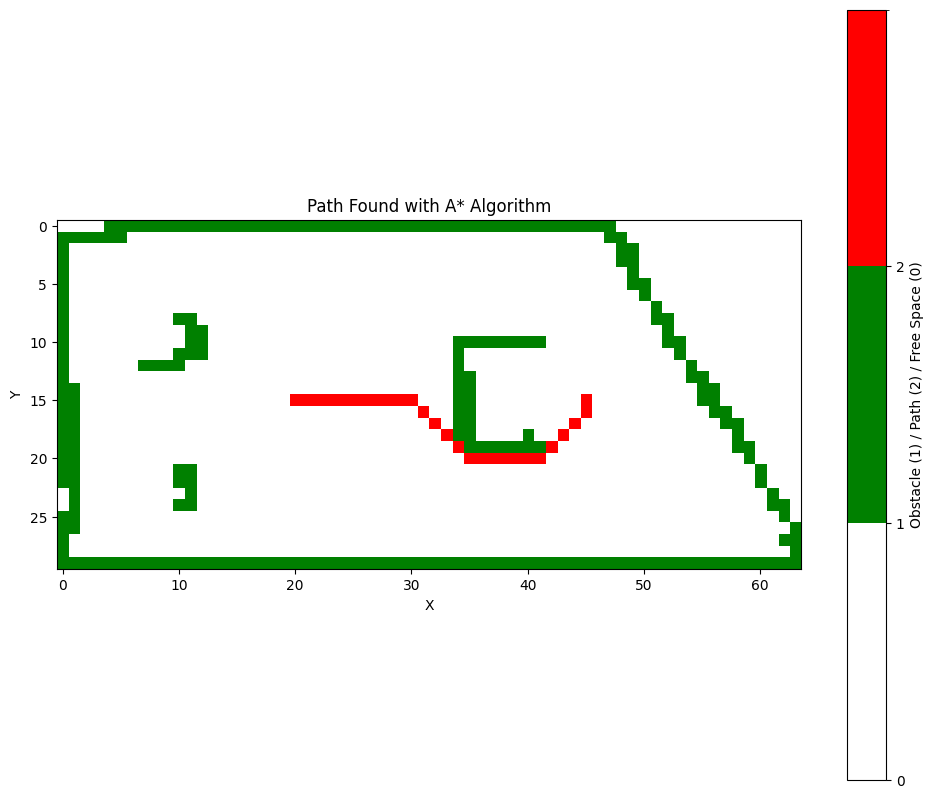

In [37]:
import matplotlib.colors as mcolors

# Create a grid for visualization
path_grid = np.copy(merged_grid_flipped_vertical)
for x, y in path:
    path_grid[x, y] = 2  # Mark the path with a different value (2)

# Create a custom colormap: black (obstacle), green (free space), and red (path)
cmap = mcolors.ListedColormap(['white', 'green', 'red'])  # Mapping [0, 1, 2] -> green, red, black
bounds = [0, 1, 2, 3]  # Boundaries for the 3 classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the merged grid with the path
plt.figure(figsize=(12, 10))
plt.imshow(path_grid, cmap=cmap, norm=norm, interpolation='nearest')
plt.title('Path Found with A* Algorithm')
plt.xlabel('X')
plt.ylabel('Y')

# Adding a colorbar for reference
plt.colorbar(ticks=[0, 1, 2], label='Obstacle (1) / Path (2) / Free Space (0)')
plt.show()

# Ho ho ho Merry Christmas <3